# Predictive maintenance using machine learning techniques(by SVM)

Our task is to classify these 10 types of fault given time data. There are many approaches to solve this. We will take one known as 'Shallow Approach'. In the age of deep learning these methods are shallow for several reasons. These methods require hand crafted features to be designed and fed into the learning algorithm. Another name for shallow approach is feature based approach. We will use support vector machine (SVM) to do the classification. We will apply other techniques including machin learning techniques in later posts.

   We have used time domain features as input to SVM. First data for each fault type are collected and segmented into smaller parts. In our case, one segment for each fault type contains 2048 data points. Then time domain features for each segment are calculated and assembled in a feature matrix. There are 230 segments for each fault and we have taken 9 time domain features. The time domain features are maximum, minimum, mean value, standard deviation, root mean square value (RMS), skewness, kurtosis, crest factor, and form factor. Thus our feature matrix is of size (2300×9). One column containing fault type is also added to the feature matrix. Thus final feature matrix is of size (2300×10).

Import used libraries

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

Read data:
we are reading the data file (which you downloaded from Kaggle) from Google Drive

In [16]:
data= pd.read_csv('feature_time_48k_2048_load_1.csv')

In [17]:
data

,max,min,mean,sd,rms,skewness,kurtosis,crest,form,fault
0,0.35986,-0.41890,0.017840,0.122746,0.124006,-0.118571,-0.042219,2.901946,6.950855,Ball_007_1
1,0.46772,-0.36111,0.022255,0.132488,0.134312,0.174699,-0.081548,3.482334,6.035202,Ball_007_1
2,0.46855,-0.43809,0.020470,0.149651,0.151008,0.040339,-0.274069,3.102819,7.376926,Ball_007_1
3,0.58475,-0.54303,0.020960,0.157067,0.158422,-0.023266,0.134692,3.691097,7.558387,Ball_007_1
4,0.44685,-0.57891,0.022167,0.138189,0.139922,-0.081534,0.402783,3.193561,6.312085,Ball_007_1
...,...,...,...,...,...,...,...,...,...,...
2295,0.21425,-0.19839,0.010769,0.064100,0.064983,-0.212497,-0.119312,3.297037,6.034174,Normal_1
2296,0.21967,-0.20882,0.013136,0.068654,0.069883,-0.061308,-0.295122,3.143410,5.319958,Normal_1
2297,0.20799,-0.21613,0.012571,0.067128,0.068279,-0.154754,-0.071405,3.046161,5.431299,Normal_1
2298,0.21425,-0.22405,0.012608,0.066813,0.067977,-0.326966,0.023662,3.151821,5.391672,Normal_1


In [18]:
data['fault'] = pd.Categorical(data['fault'])

Divide the into training and test set.

In [19]:
train_data, test_data = train_test_split(data, test_size = 0.2, stratify = data['fault'],
                                         random_state = 123)
test_data['fault'].value_counts()

Ball_007_1    46
Ball_014_1    46
Ball_021_1    46
IR_007_1      46
IR_014_1      46
IR_021_1      46
Normal_1      46
OR_007_6_1    46
OR_014_6_1    46
OR_021_6_1    46
Name: fault, dtype: int64

Data preprocessing:
Before applying SVM, it is always a better idea to scale the data.

In [20]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.iloc[:,:-1])
test_data_scaled = (test_data.iloc[:,:-1].values - scaler.mean_)/np.sqrt(scaler.var_)

Model of support vector machine:

We will check a grid of parameters to find the best one. For each parameter combination, 10 fold cross-validation is performed.

In [21]:
parameters = {"C":[1, 10, 50, 100, 500, 5000],
             'gamma':[0.05, 0.1, 0.5, 1, 5],
             'kernel':["linear"]}
tuned_svm_clf = GridSearchCV(SVC(),parameters,n_jobs = -1, cv= 10)
tuned_svm_clf.fit(train_data_scaled, train_data['fault'])

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 500, 5000],
                         'gamma': [0.05, 0.1, 0.5, 1, 5],
                         'kernel': ['linear']})

In [22]:
tuned_svm_clf.best_score_

0.9668478260869566

In [23]:
tuned_svm_clf.best_params_

{'C': 50, 'gamma': 0.05, 'kernel': 'linear'}

Now we will used the best model to find test accuracy.

In [24]:
best_clf = tuned_svm_clf.best_estimator_
best_clf

SVC(C=50, gamma=0.05, kernel='linear')

Prediction of Model:

In [25]:
train_predictions = best_clf.predict(train_data_scaled)
test_predictions = best_clf.predict(test_data_scaled)
#confusion matrix of train and test
train_confu_matrix = confusion_matrix(train_data['fault'], train_predictions)
test_confu_matrix = confusion_matrix(test_data['fault'], test_predictions)

Plot the Train of confusion matrix.

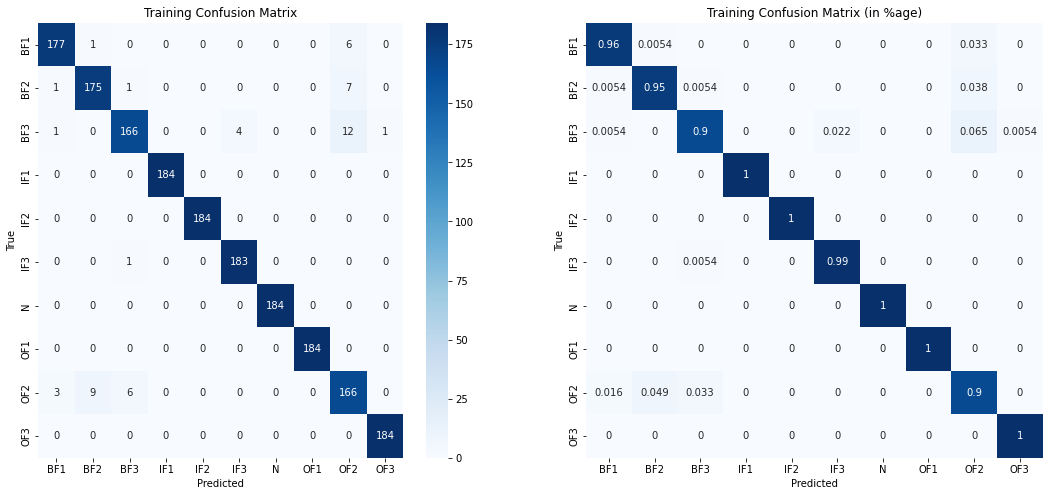

In [26]:
fault_type = ['BF1','BF2','BF3','IF1','IF2','IF3','N','OF1','OF2','OF3']
plt.figure(1,figsize=(18,8))
plt.subplot(121)
sns.heatmap(train_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(train_confu_matrix/184, annot= True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Plot the test of confusion matrix.

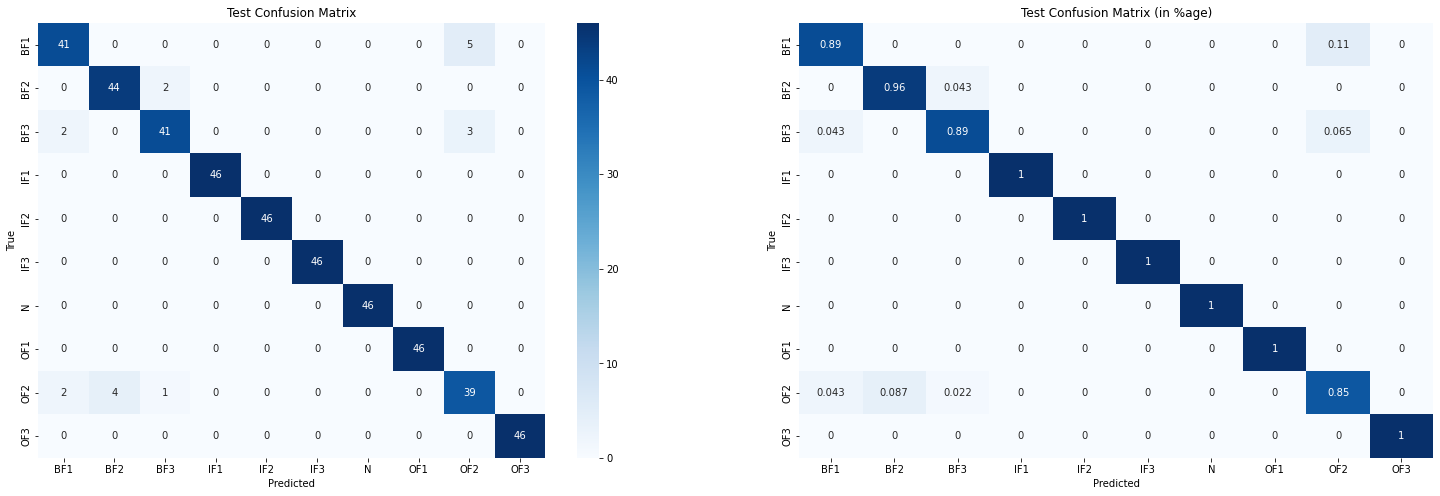

In [27]:
plt.figure(2,figsize=(25,8))
plt.subplot(121)
sns.heatmap(test_confu_matrix, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(test_confu_matrix/46, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
overall_test_accuracy = accuracy_score(test_data['fault'], test_predictions)
print("Overall test accuracy: ", overall_test_accuracy)

Overall test accuracy:  0.9586956521739131


The overall test accuracy is 95.87% which is pretty satisfactory considering the fact that we are only taking time domain features